## K-means Clustering in Python using OpenAI

We use a simple k-means algorithm to demonstrate how clustering can be done. Clustering can help discover valuable, hidden groupings within the data. The dataset is created in the [Get_embeddings_from_dataset Notebook](Get_embeddings_from_dataset.ipynb).

In [1]:
# imports
import numpy as np
import pandas as pd
from ast import literal_eval

# load data
datafile_path = "./data/clusterization/fine_food_reviews_with_embeddings_1k.csv"

df = pd.read_csv(datafile_path)
df["embedding"] = df.embedding.apply(literal_eval).apply(np.array)  # convert string to numpy array
matrix = np.vstack(df.embedding.values)
matrix.shape


(1000, 1536)

### 1. Find the clusters using K-means

We show the simplest use of K-means. You can pick the number of clusters that fits your use case best.

In [4]:
from sklearn.cluster import KMeans

n_clusters = 5

kmeans = KMeans(n_clusters=n_clusters, init="k-means++", random_state=42)
kmeans.fit(matrix)
labels = kmeans.labels_
df["Cluster"] = labels

df.groupby("Cluster").Score.mean().sort_values()


Cluster
0    4.040462
3    4.184211
4    4.186567
2    4.255663
1    4.365979
Name: Score, dtype: float64

Text(0.5, 1.0, 'Clusters identified visualized in language 2d using t-SNE')

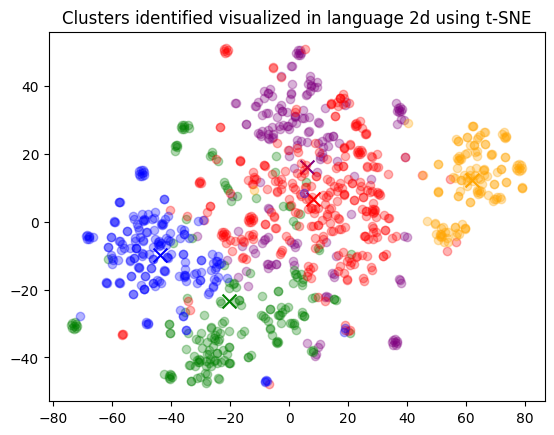

In [6]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

tsne = TSNE(n_components=2, perplexity=15, random_state=42, init="random", learning_rate=200)
vis_dims2 = tsne.fit_transform(matrix)

x = [x for x, y in vis_dims2]
y = [y for x, y in vis_dims2]

for category, color in enumerate(["purple", "green", "red", "blue", "orange"]):
    xs = np.array(x)[df.Cluster == category]
    ys = np.array(y)[df.Cluster == category]
    plt.scatter(xs, ys, color=color, alpha=0.3)

    avg_x = xs.mean()
    avg_y = ys.mean()

    plt.scatter(avg_x, avg_y, marker="x", color=color, s=100)
plt.title("Clusters identified visualized in language 2d using t-SNE")


Visualization of clusters in a 2d projection.

### 2. Text samples in the clusters & naming the clusters

Let's show random samples from each cluster. We'll use gpt-4 to name the clusters, based on a random sample of 5 reviews from that cluster.

In [7]:
import os
import dotenv
from openai import OpenAI

dotenv.load_dotenv()

client = OpenAI()

# Reading a review which belong to each group.
rev_per_cluster = 5

for i in range(n_clusters):
    print(f"Cluster {i} Theme:", end=" ")

    reviews = "\n".join(
        df[df.Cluster == i]
        .combined.str.replace("Title: ", "")
        .str.replace("\n\nContent: ", ":  ")
        .sample(rev_per_cluster, random_state=42)
        .values
    )

    messages = [
        {"role": "user", "content": f'What do the following customer reviews have in common?\n\nCustomer reviews:\n"""\n{reviews}\n"""\n\nTheme:'}
    ]

    response = client.chat.completions.create(
        model="gpt-4",
        messages=messages,
        temperature=0,
        max_tokens=64,
        top_p=1,
        frequency_penalty=0,
        presence_penalty=0)
    print(response.choices[0].message.content.replace("\n", ""))

    sample_cluster_rows = df[df.Cluster == i].sample(rev_per_cluster, random_state=42)
    for j in range(rev_per_cluster):
        print(sample_cluster_rows.Score.values[j], end=", ")
        print(sample_cluster_rows.Summary.values[j], end=":   ")
        print(sample_cluster_rows.Text.str[:70].values[j])

    print("-" * 100)


Cluster 0 Theme: Food products
2, Poor germination rate:   I had high expectations of these seeds, but I was disappointed! About 
5, musical fruit:   Perfect pantry basic on the non meat protein shelf.  Long shelf life, 
5, Whole Grain Food for great Health Benefit:   I love the taste and ease of cooking this rice.  The reason for making
5, Best cup of noodles ever!:   Tried many (from all over the world) different types of packaged quick
5, Tasty and easy to use.:   Everyone that dips with this loves it!  So easy to use! Olive oil and 
----------------------------------------------------------------------------------------------------
Cluster 1 Theme: The theme of these customer reviews is food and drink products.
5, Homemade Vanilla Extract:   I have always bought my pure vanilla extract in Mexico, but got a tip 
5, I couldn't love the double bergamot more:   I'm absolutely addicted to this tea. it's the best tea I've ever had. 
5, Great flavor!:   I purchased this in a local health 

It's important to note that clusters will not necessarily match what you intend to use them for. A larger amount of clusters will focus on more specific patterns, whereas a small number of clusters will usually focus on largest discrepencies in the data.

# Let's try to do it with OpenAI completions

In [9]:
df.head()

,Unnamed: 0,ProductId,UserId,Score,Summary,Text,combined,n_tokens,embedding,Cluster
0,0,B003XPF9BO,A3R7JR3FMEBXQB,5,where does one start...and stop... with a tre...,Wanted to save some to bring to my Chicago fam...,Title: where does one start...and stop... wit...,52,"[0.03599238395690918, -0.02116263099014759, -0...",2
1,297,B003VXHGPK,A21VWSCGW7UUAR,4,"Good, but not Wolfgang Puck good","Honestly, I have to admit that I expected a li...","Title: Good, but not Wolfgang Puck good; Conte...",178,"[-0.07042013108730316, -0.03175969794392586, -...",3
2,296,B008JKTTUA,A34XBAIFT02B60,1,Should advertise coconut as an ingredient more...,"First, these should be called Mac - Coconut ba...",Title: Should advertise coconut as an ingredie...,78,"[0.05692615360021591, -0.005402443464845419, 0...",2
3,295,B000LKTTTW,A14MQ40CCU8B13,5,Best tomato soup,I have a hard time finding packaged food of an...,Title: Best tomato soup; Content: I have a har...,111,"[-0.011223138310015202, -0.049720242619514465,...",0
4,294,B001D09KAM,A34XBAIFT02B60,1,Should advertise coconut as an ingredient more...,"First, these should be called Mac - Coconut ba...",Title: Should advertise coconut as an ingredie...,78,"[0.05692615360021591, -0.005402443464845419, 0...",2


In [10]:
# create a new df with only the columns we need (score, summary, text)
df2 = df[["Score", "Summary", "Text"]].copy()
df2

,Score,Summary,Text
0,5,where does one start...and stop... with a tre...,Wanted to save some to bring to my Chicago fam...
1,4,"Good, but not Wolfgang Puck good","Honestly, I have to admit that I expected a li..."
2,1,Should advertise coconut as an ingredient more...,"First, these should be called Mac - Coconut ba..."
3,5,Best tomato soup,I have a hard time finding packaged food of an...
4,1,Should advertise coconut as an ingredient more...,"First, these should be called Mac - Coconut ba..."
...,...,...,...
995,1,Strange inflammation response,Truthfully wasn't crazy about the taste of the...
996,5,My favorite and only MUSTARD,You've just got to experience this mustard... ...
997,5,My furbabies LOVE these!,Shake the container and they come running. Eve...
998,5,got this for the daughter,all i have heard since she got a kuerig is why...


In [11]:
# enumerate it and save to csv
df2.to_csv("data/classification/fine_food_reviews_for_openai.csv", index=False)

In [17]:
# upload the file to OpenAI
file = client.files.create(file=open("data/classification/fine_food_reviews_for_openai.csv", "rb"), purpose="assistants")


In [78]:
# call the openai api to get the completions based on the file
assistant = client.beta.assistants.create(
  instructions=""
               "You are a clustering tool. "
               "You are analyzing provided by user information from .json file and need to find the clusters using K-means algorithm. "
               "Also you have to define grouping names for the clusters based on the main objects grouping idea of the each cluster (up to 10 words of the main grouping idea)."
               "Provide the response_format as json_object formated as: "
               "{cluster 1 number: {\"name\": \"The grouping name, defined for cluster 1\",\"objects_count\": \"count of objects in cluster 1\", \"examples\": [list of first 3 objects of the cluster]}, "
               "cluster 2 number: {\"name\": \"The grouping name, defined for cluster 2\",\"objects_count\": \"count of objects in cluster 2\", \"examples\": [list of first 3 objects of the cluster]},...}"
               "Please respond only in json_object format. Do not add any additional information above or below.",
  model="gpt-4o-mini",
  tools=[{"type": "code_interpreter"}],
  # response_format={ "type": "json_object" },
)

In [79]:
thread = client.beta.threads.create(
  messages=[
    {
      "role": "user",
      "content": "Read the provided CSV file with reviews. Make clusterization using K-means algorithm."
                 "Number of clusters: 4.",
      "attachments": [
        {
          "file_id": file.id,
          "tools": [{"type": "code_interpreter"}]
        }
      ],
    }
  ]
)
thread

Thread(id='thread_eOlOnGr3mE7WTzz83JS6jYw8', created_at=1729067446, metadata={}, object='thread', tool_resources=ToolResources(code_interpreter=ToolResourcesCodeInterpreter(file_ids=['file-Gjk16k6ESbfhCkDdEdpbX8tf']), file_search=None))

In [80]:
run = client.beta.threads.runs.create_and_poll(
    thread_id=thread.id, 
    assistant_id=assistant.id,
)

messages = list(client.beta.threads.messages.list(thread_id=thread.id, run_id=run.id))

In [37]:
# messages

In [81]:
messages[0].content[0].text.value

'```json\n{\n    "0": {\n        "name": "Highly positive reviews about products",\n        "objects_count": "578",\n        "examples": [\n            "where does one  start...and stop... with a treat like this",\n            "Best tomato soup",\n            "These fresh berries are truly MIRACULOUS!!!"\n        ]\n    },\n    "1": {\n        "name": "Mixed or moderate feedback reviews",\n        "objects_count": "243",\n        "examples": [\n            "Loved these gluten free healthy bars, saved $$ ordering on Amazon",\n            "Loved these gluten free healthy bars, saved $$ ordering on Amazon",\n            "spicy"\n        ]\n    },\n    "2": {\n        "name": "Negative feedback and complaints",\n        "objects_count": "72",\n        "examples": [\n            "Should advertise coconut as an ingredient more prominently",\n            "Should advertise coconut as an ingredient more prominently",\n            "Should advertise coconut as an ingredient more prominently"\n   

In [84]:
import json

response = messages[0].content[0].text.value
response = response.replace("```json\n", "").replace("```", "")

# Parse the response
try:
    clusters = json.loads(response)
except json.JSONDecodeError:
    clusters = {}
    print("Failed to parse JSON response.")


clusters

{'0': {'name': 'Highly positive reviews about products',
  'objects_count': '578',
  'examples': ['where does one  start...and stop... with a treat like this',
   'Best tomato soup',
   'These fresh berries are truly MIRACULOUS!!!']},
 '1': {'name': 'Mixed or moderate feedback reviews',
  'objects_count': '243',
  'examples': ['Loved these gluten free healthy bars, saved $$ ordering on Amazon',
   'Loved these gluten free healthy bars, saved $$ ordering on Amazon',
   'spicy']},
 '2': {'name': 'Negative feedback and complaints',
  'objects_count': '72',
  'examples': ['Should advertise coconut as an ingredient more prominently',
   'Should advertise coconut as an ingredient more prominently',
   'Should advertise coconut as an ingredient more prominently']},
 '3': {'name': 'Excellent products and experiences',
  'objects_count': '107',
  'examples': ['Good, but not Wolfgang Puck good',
   'Great Monster product',
   'Great coffee, not bitter.']}}